VAE

In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as kl
from keras import backend as K
from keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt


In [2]:
class Encorder(tf.keras.Model):
    def __init__(self,input_size,z_size):
        super(Encorder,self).__init__()
        self.input_dim=input_size
        self.z_dim=z_size
        
        #入力層
        input_layer=c=kl.Input(shape=(self.input_dim,))        
        
        #中間層
        c=kl.Reshape((32,32,3))(c)
        c=kl.Conv2D(32,kernel_size=4,strides=2,activation='relu')(c)
        c=kl.Conv2D(64,kernel_size=4,strides=2,activation='relu')(c)
        c=kl.Conv2D(128,kernel_size=4,strides=2,activation='relu')(c)
        c=kl.Flatten()(c)
        # c=kl.Dense(32,activation='relu')(c)
        # c=kl.Dense(64,activation='relu')(c)
        # c=kl.Dense(128,activation='relu')(c)
        self.hidden_layer=keras.Model(input_layer,c)
                
        #出力層
        self.dence_mu=kl.Dense(self.z_dim,activation='linear')
        self.dence_sigma=kl.Dense(self.z_dim,activation='linear')
        
    def call(self,x_input):
        #ネットワークの計算
    
        x=self.hidden_layer(x_input)
        mu=self.dence_mu(x)
        log_sigma=self.dence_sigma(x)
        
        
        eps=K.random_normal(shape=(self.z_dim,),mean=0.0,stddev=0.1)
        z=mu+K.exp(log_sigma)*eps
        
        return mu,log_sigma,z
    
class Decorder(keras.Model):
    def __init__(self,input_size,z_size):
        super(Decorder,self).__init__()
        self.input_dim=input_size
        self.z_dim=z_size
        #入力層
        input_layer=c=kl.Input(shape=(self.z_dim,))
        
        #中間層
        # c=kl.Dense(32,activation='relu')(c)
        # c=kl.Dense(64,activation='relu')(c)
        c=kl.Dense(2*2*64,activation='relu')(c)
        c=kl.Reshape((1,1,2*2*64))(c)
        c=kl.Conv2DTranspose(128,kernel_size=5,strides=2,activation='relu',padding='valid')(c)
        c=kl.Conv2DTranspose(64,kernel_size=5,strides=2,activation='relu',padding='valid')(c)
        c=kl.Conv2DTranspose(32,kernel_size=6,strides=2,activation='relu',padding='valid')(c)
        c=kl.Conv2DTranspose(3,kernel_size=6,strides=2,activation='relu',padding='valid')(c)
        c=kl.Flatten()(c)
        self.hidden_layer=keras.Model(input_layer,c)
        
        #出力層
        self.output_layer=kl.Dense(self.input_dim,activation='sigmoid')
        
    def call(self,x):
        #ネットワークの計算
        x=self.hidden_layer(x)
        x=self.output_layer(x)
        
        return x
    
    
class VAE(keras.Model):
    def __init__(self,input_size,z_size):
        super(VAE,self).__init__()
        self.encoder=Encorder(input_size,z_size)
        self.decoder=Decorder(input_size,z_size)
        
    def call(self,x):
        mu,log_sigma,z=self.encode(x)
        x_decoded=self.decode(z)
        return x_decoded,mu,log_sigma,z
        
    def encode(self,x):
        mu,log_sigma,z=self.encoder(x)
        return mu,log_sigma,z
        
    def decode(self,z):
        x=self.decoder(z)
        return x
        
        
        
def loss_function(label, predict, mu, log_sigma): 
  reconstruction_loss = tf.keras.losses.binary_crossentropy(label, predict) #再構成誤差
  reconstruction_loss *= 768 
  kl_loss = 1 + log_sigma - K.square(mu) - K.exp(log_sigma) #KLダイバージェンス
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  return vae_loss

@tf.function
def train_step(x):
    loss=0
    with tf.GradientTape() as tape:
        x_decoded,mu,log_sigma,z=model(x)
        loss+=loss_function(x,x_decoded,mu,log_sigma)
    batch_loss=(loss/len(x))
    variables=model.trainable_variables
    gradients=tape.gradient(loss,variables)
    optimizer.apply_gradients(zip(gradients,variables))
    
    return batch_loss

In [3]:
#Mnistを用意
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [31]:
optimizer=keras.optimizers.Adam(learning_rate=0.001)

BUFFER_SIZE = 256
BATCH_SIZE = 256
dataset = tf.data.Dataset.from_tensor_slices((x_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
step_per_epoch=len(x_train)//BATCH_SIZE
 
model=VAE(input_size=x_train.shape[-1],z_size=16)

EPOCHS=300
for epoch in range(EPOCHS):
    # if epoch%100==0:
    #     mu,log_sigma,z=model.encode(x_test)
    #     z=z.numpy()
    #     plt.figure(figsize=(10,10))
    #     for i in range(10):
    #         index=y_test==i
    #         plt.scatter(z[index,0],z[index,1],label=str(i))
    #         z1_mean=np.mean(z[index,0]).mean()
    #         z2_mean=np.mean(z[index,1]).mean()
    #         plt.annotate(str(i),xy=(z1_mean,z2_mean))
        
    #     plt.legend()
    #     plt.show()
    
    for batch,x in enumerate(dataset):
        loss=train_step(x)
    print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1,batch,loss))

Epoch 1 Batch 194 Loss 1.7655
Epoch 2 Batch 194 Loss 1.7865
Epoch 3 Batch 194 Loss 1.7612
Epoch 4 Batch 194 Loss 1.7515
Epoch 5 Batch 194 Loss 1.7729
Epoch 6 Batch 194 Loss 1.7767
Epoch 7 Batch 194 Loss 1.7730
Epoch 8 Batch 194 Loss 1.7699
Epoch 9 Batch 194 Loss 1.7621
Epoch 10 Batch 194 Loss 1.7427
Epoch 11 Batch 194 Loss 1.7700
Epoch 12 Batch 194 Loss 1.7589
Epoch 13 Batch 194 Loss 1.7370
Epoch 14 Batch 194 Loss 1.7609
Epoch 15 Batch 194 Loss 1.7743
Epoch 16 Batch 194 Loss 1.7576
Epoch 17 Batch 194 Loss 1.7512
Epoch 18 Batch 194 Loss 1.7641
Epoch 19 Batch 194 Loss 1.7749
Epoch 20 Batch 194 Loss 1.7591
Epoch 21 Batch 194 Loss 1.7579
Epoch 22 Batch 194 Loss 1.7477
Epoch 23 Batch 194 Loss 1.7728
Epoch 24 Batch 194 Loss 1.7492
Epoch 25 Batch 194 Loss 1.7624
Epoch 26 Batch 194 Loss 1.7693
Epoch 27 Batch 194 Loss 1.7563
Epoch 28 Batch 194 Loss 1.7847
Epoch 29 Batch 194 Loss 1.7661
Epoch 30 Batch 194 Loss 1.7651
Epoch 31 Batch 194 Loss 1.7672
Epoch 32 Batch 194 Loss 1.7438
Epoch 33 Batch 19

ラベル:  [0]


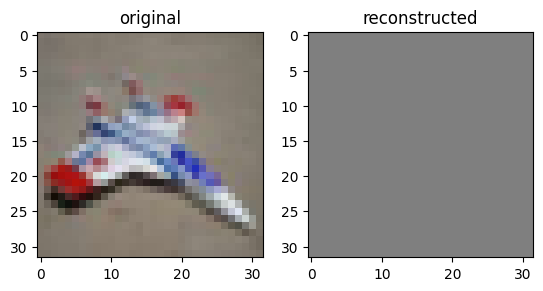

In [34]:
i = 30
reconstructed,mu, log_sigma,  z = model(x_train[i].reshape(1, -1))# * 255
print('ラベル: ', y_train[i])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(x_train[i].reshape(32, 32, 3))
ax[0].set_title('original')
ax[1].imshow(reconstructed.numpy().reshape(32, 32, 3))
ax[1].set_title('reconstructed')
plt.show()